In [1]:
# z5499630 Boyang, Peng

# COMP9414 Project 2
## z5499630 Boyang, Peng


In this project, I will be implementing Q-learning and SARSA methods for a taxi navigation problem using the Gym library, an open-source Python library for developing and comparing reinforcement learning algorithms. 


# Taxi[1]

This environment is part of the Toy Text environments. Please read that page first for general information.

| Item              | Properties          |
|-------------------|---------------------|
| Action Space      | Discrete(6)         |
| Observation Space | Discrete(500)       |
| Import            | `gym.make("Taxi-v3")` |

The Taxi Problem from “Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition” by Tom Dietterich



## Description:

There are four designated locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger’s location, picks up the passenger, drives to the passenger’s destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends.

## Map:

```text
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
```


## Actions:

There are 6 discrete deterministic actions:

`0: move south`

`1: move north`

`2: move east`

`3: move west`

`4: pickup passenger`

`5: drop off passenger`

## Observations:

There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations.

Note that there are 400 states that can actually be reached during an episode. The missing states correspond to situations in which the passenger is at the same location as their destination, as this typically signals the end of an episode. Four additional states can be observed right after a successful episodes, when both the passenger and the taxi are at the destination. This gives a total of 404 reachable discrete states.

Each state space is represented by the tuple: `(taxi_row, taxi_col, passenger_location, destination)`

An observation is an integer that encodes the corresponding state. The state tuple can then be decoded with the “decode” method.

Passenger locations:

0: R(ed)

1: G(reen)

2: Y(ellow)

3: B(lue)

4: in taxi

Destinations:

0: R(ed)

1: G(reen)

2: Y(ellow)

3: B(lue)

## Rewards:
`-1` per step unless other reward is triggered.

`+20` delivering passenger.

`-10` executing “pickup” and “drop-off” actions illegally.


# Step 1: Creating the Taxi-v3 enviornment

In [2]:
import gym
import matplotlib.pyplot as plt
import numpy as np

# Create the Taxi-v3 environment
env = gym.make('Taxi-v3')

# Get the number of states and actions from the environment
n_states = env.observation_space.n
n_actions = env.action_space.n

# Print the number of states and actions for reference
print(n_states, n_actions)

500 6


# Step 2: Define the greedy method and the epsilon greedy method

Definition:
The epsilon-greedy action method is a strategy in reinforcement learning to balance exploration (trying new actions) and exploitation (choosing the best-known action).

Action Selection:

With probability $\epsilon$, choose a random action (explore).

With probability 1 − $\epsilon$, choose the action with the highest Q-value (exploit).

When $\epsilon$ = 0:

The agent always exploits the best-known action based on current Q-values. The agent will not explore new actions, potentially missing better strategies. It might get stuck in a local optimum and fail to discover the globally optimal solution.

When $\epsilon$ = 1:

The agent always explores by choosing random actions. The agent will not exploit the knowledge it has gained, leading to suboptimal performance as it never takes advantage of the best-known actions.

In [3]:
def greedy(Q, state):
    # Select the action with the highest Q-value for the given state
    return np.argmax(Q[state])

def epsilon_greedy(Q, state, epsilon):
    # With probability epsilon, select a random action (exploration)
    if np.random.uniform(0, 1) < epsilon:
        return np.random.choice(len(Q[state]))  # Explore
    else:
        # Otherwise, select the action with the highest Q-value (exploitation)
        return np.argmax(Q[state])  # Exploit

# Step 3: Setting Hyperparameters for training

Discount Factor (γ):
- High γ: Values future rewards, promoting long-term planning.
- γ=1: Values future rewards equally as immediate ones; promotes long-term planning but can slow down learning.

- Low γ: Values immediate rewards, leading to short-term focus.
- γ=0: Focuses only on immediate rewards; ignores future rewards, leading to short-sighted behavior.


Learning Rate (α):
- High α: Enables fast learning but can cause instability.
- α=1: Learns very quickly; can cause instability and erratic behavior due to overreacting to recent experiences.

- Low α: Provides stable updates but slows down learning.
- α=0: No learning occurs; the agent's policy remains static.

In [4]:
# Hyperparameters
alpha = 0.5  # Learning rate
gamma = 0.9  # Discount factor
episodes = 2000  # Number of episodes for training

# Step 4: Define the Q-learning training method

**SARSA (State-Action-Reward-State-Action)**:
- An on-policy algorithm that updates Q-values based on the actual actions taken, leading to more stable and safer learning.

**Q-Learning**:
- An off-policy algorithm that updates Q-values based on the maximum possible reward from the next state, resulting in faster convergence but potentially riskier policies.

**Comparison**:
- **SARSA** is better for environments requiring stability and less risky moves, while **Q-Learning** is suited for scenarios where finding the optimal policy quickly is more important.

### The Q-learning update rule:

$$Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right] $$

$Q(s,a)$ is the current Q-value for state $s$ and action $a$.

$\alpha$ is the learning rate.

$r$ is the reward received after taking action $a$ in state $s$.

$\gamma$ is the discount factor.

$s'$  is the next state.

$a'$ is the action taken in the next state $s'$

$\max_{a'} Q(s',a')$ is the maximum Q-value for the next state over all possible actions in Q-learning.



In [5]:
# Q-learning
def q_learning(env, Q, alpha, gamma, episodes, epsilon, method='epsilon_greedy'):
    rewards_per_episode = []
    steps_per_episode = []

    for _ in range(episodes):
        # Reset the environment and get the initial state
        state_info = env.reset()
        state = state_info[0]
        total_rewards = 0
        steps = 0
        done = False

        # Continue until the episode is done
        while not done:
            # Select action based on the input method (greedy or epsilon-greedy)
            if method == 'greedy':
                action = greedy(Q, state)
            elif method == 'epsilon_greedy':
                action = epsilon_greedy(Q, state, epsilon)

            # Perform the action and get the next state and reward
            next_state_info, reward, done, _, _ = env.step(action)
            next_state = next_state_info

            # Update the Q-value using the Q-learning update rule
            Q[state, action] = Q[state, action] + alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])

            # Move to the next state
            state = next_state
            total_rewards += reward
            steps += 1

        # Store the total rewards and steps for this episode
        rewards_per_episode.append(total_rewards)
        steps_per_episode.append(steps)

    return Q, rewards_per_episode, steps_per_episode

# Step 5: Define the SARSA training method

### The SARSA update rule:

$$Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma Q(s', a') - Q(s, a) \right] $$

$Q(s,a)$ is the current Q-value for state $s$ and action $a$.

$\alpha$ is the learning rate.

$r$ is the reward received after taking action $a$ in state $s$.

$\gamma$ is the discount factor.

$s'$  is the next state.

$a'$ is the action taken in the next state $s'$

$Q(s',a')$ is the Q-value for the next state and action in SARSA.


In [6]:
# SARSA
def sarsa(env, Q, alpha, gamma, episodes, epsilon, method='epsilon_greedy'):
    rewards_per_episode = []
    steps_per_episode = []

    for _ in range(episodes):
        # Reset the environment and get the initial state
        state_info = env.reset()
        state = state_info[0]
        total_rewards = 0
        steps = 0
        done = False

        # Select the initial action using the specified method
        if method == 'greedy':
            action = greedy(Q, state)
        elif method == 'epsilon_greedy':
            action = epsilon_greedy(Q, state, epsilon)

        # Continue until the episode is done
        while not done:
            
            # Perform the action and get the next state and reward
            next_state_info, reward, done, _, _ = env.step(action)
            next_state = next_state_info

            # Select the next action using the specified method
            if method == 'greedy':
                next_action = greedy(Q, next_state)
            elif method == 'epsilon_greedy':
                next_action = epsilon_greedy(Q, next_state, epsilon)

            # Update the Q-value using the SARSA update rule
            Q[state, action] = Q[state, action] + alpha * (reward + gamma * Q[next_state, next_action] - Q[state, action])

            # Move to the next state and action
            state = next_state
            action = next_action
            total_rewards += reward
            steps += 1

        # Store the total rewards and steps for this episode
        rewards_per_episode.append(total_rewards)
        steps_per_episode.append(steps)

    return Q, rewards_per_episode, steps_per_episode

## Experimenting with different epsilon value

In [7]:
epsilons = [0, 0.001, 0.1, 0.5]

In [8]:
# Initialize storage for results
q_learning_results = []
sarsa_results = []

for epsilon in epsilons:
    # Training the agent using Q-learning
    Q = np.zeros([n_states, n_actions])
    Q, q_rewards, q_steps = q_learning(env, Q, alpha, gamma, episodes, epsilon, method='epsilon_greedy')
    q_learning_results.append((epsilon, q_rewards, q_steps))
    
    # Training the agent using SARSA
    Q_sarsa = np.zeros([n_states, n_actions])
    Q_sarsa, sarsa_rewards, sarsa_steps = sarsa(env, Q_sarsa, alpha, gamma, episodes, epsilon, method='epsilon_greedy')
    sarsa_results.append((epsilon, sarsa_rewards, sarsa_steps))


/Users/hudson/Documents/anaconda3/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


### Plots of different epsilon values in Q-learning [0, 0.001, 0.1, 0.5]

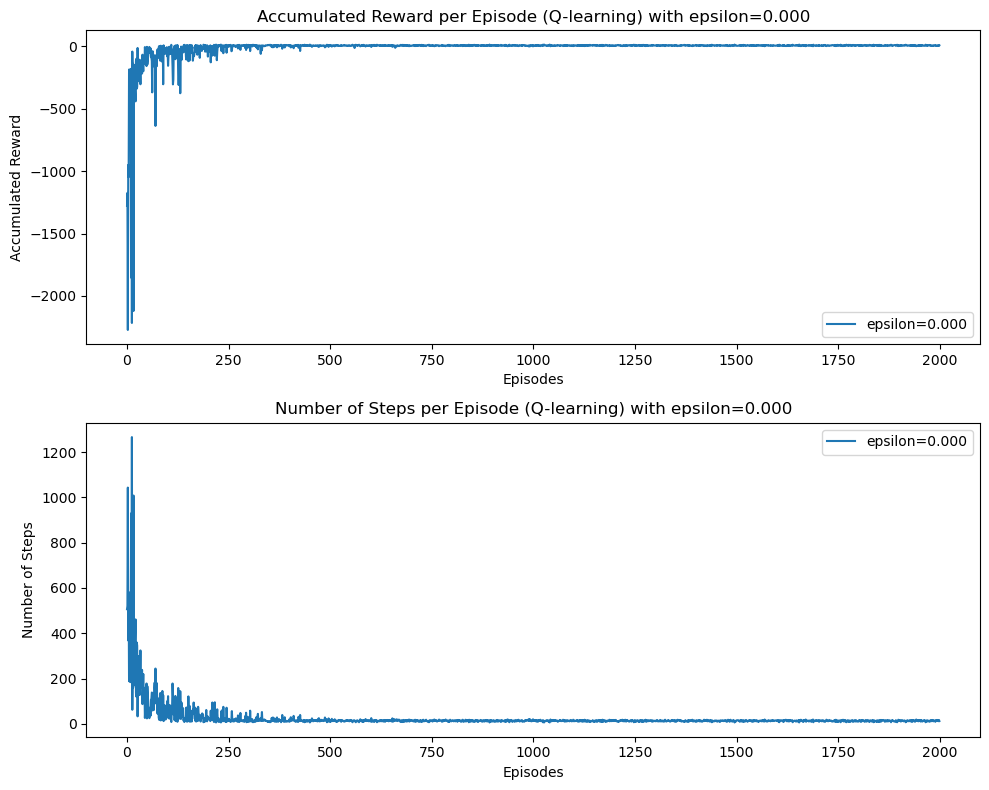

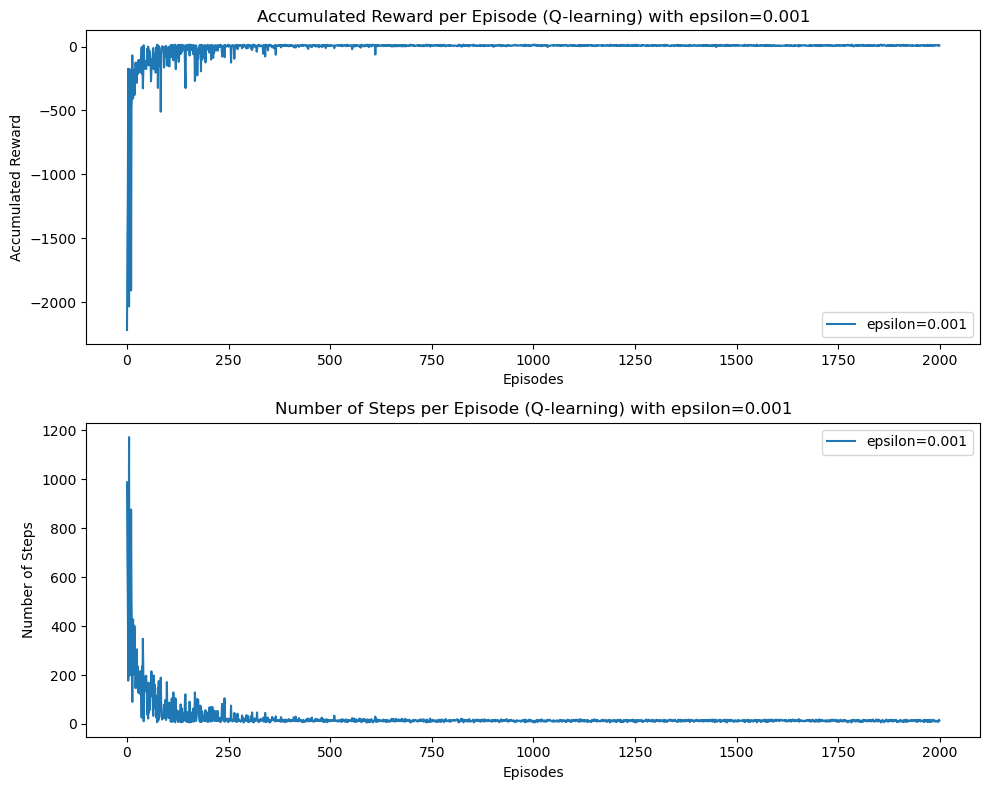

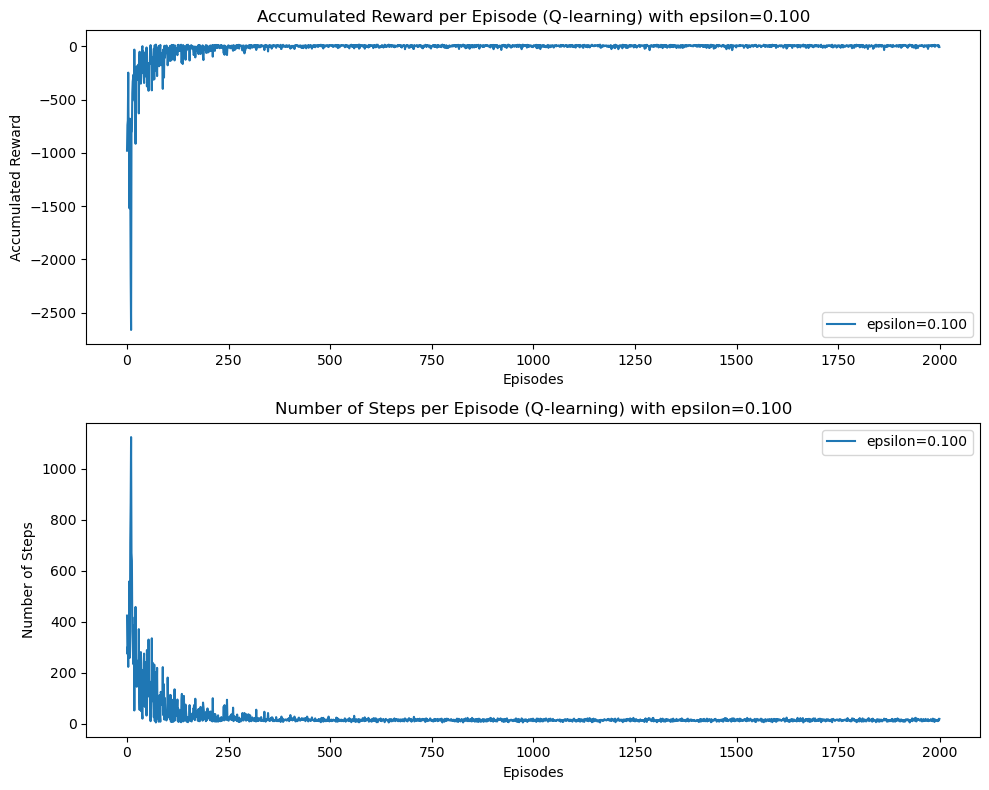

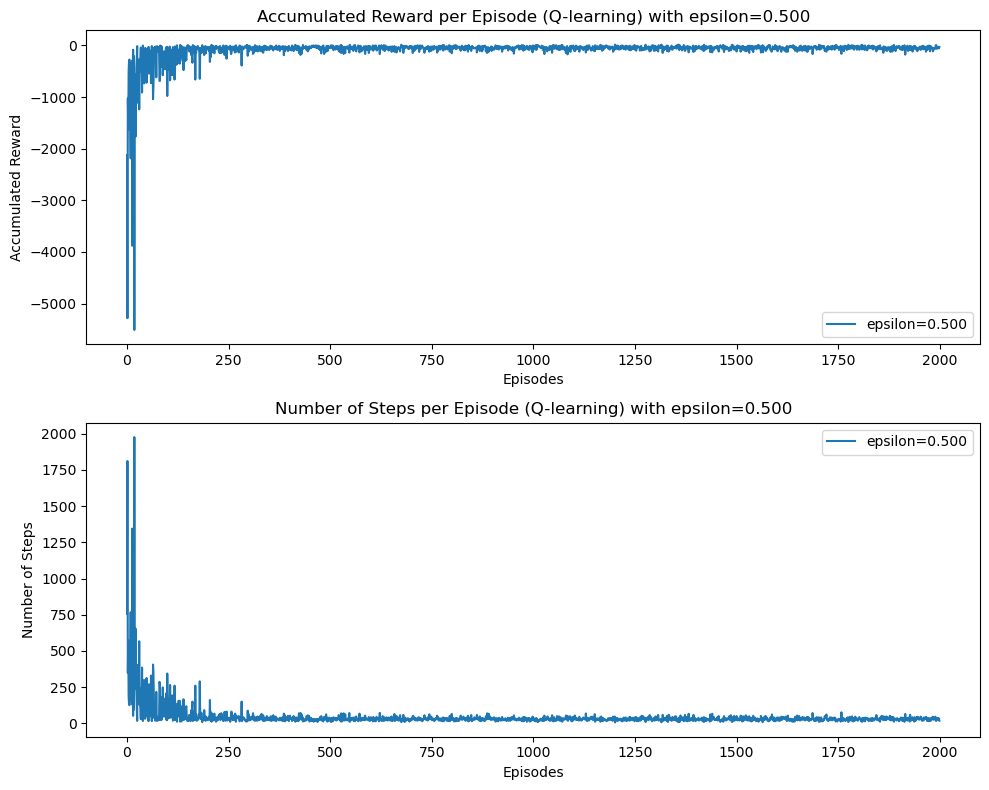

In [9]:
for epsilon, q_rewards, q_steps in q_learning_results:
    plt.figure(figsize=(10, 8))

    # Plot the accumulated rewards per episode for Q-learning
    plt.subplot(2, 1, 1)
    plt.plot(range(episodes), q_rewards, label=f'epsilon={epsilon:.3f}')
    plt.xlabel('Episodes')
    plt.ylabel('Accumulated Reward')
    plt.title(f'Accumulated Reward per Episode (Q-learning) with epsilon={epsilon:.3f}')
    plt.legend()

    # Plot the number of steps per episode for Q-learning
    plt.subplot(2, 1, 2)
    plt.plot(range(episodes), q_steps, label=f'epsilon={epsilon:.3f}')
    plt.xlabel('Episodes')
    plt.ylabel('Number of Steps')
    plt.title(f'Number of Steps per Episode (Q-learning) with epsilon={epsilon:.3f}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


### Plots of different epsilon values in SARSA [0, 0.001, 0.1, 0.5]

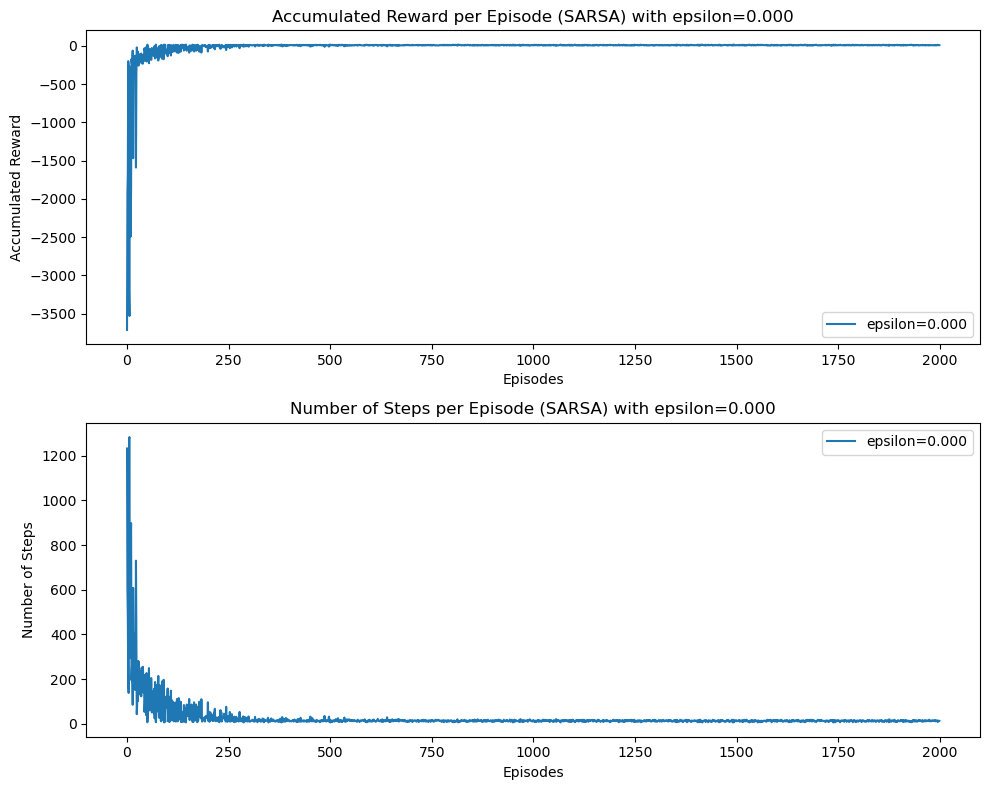

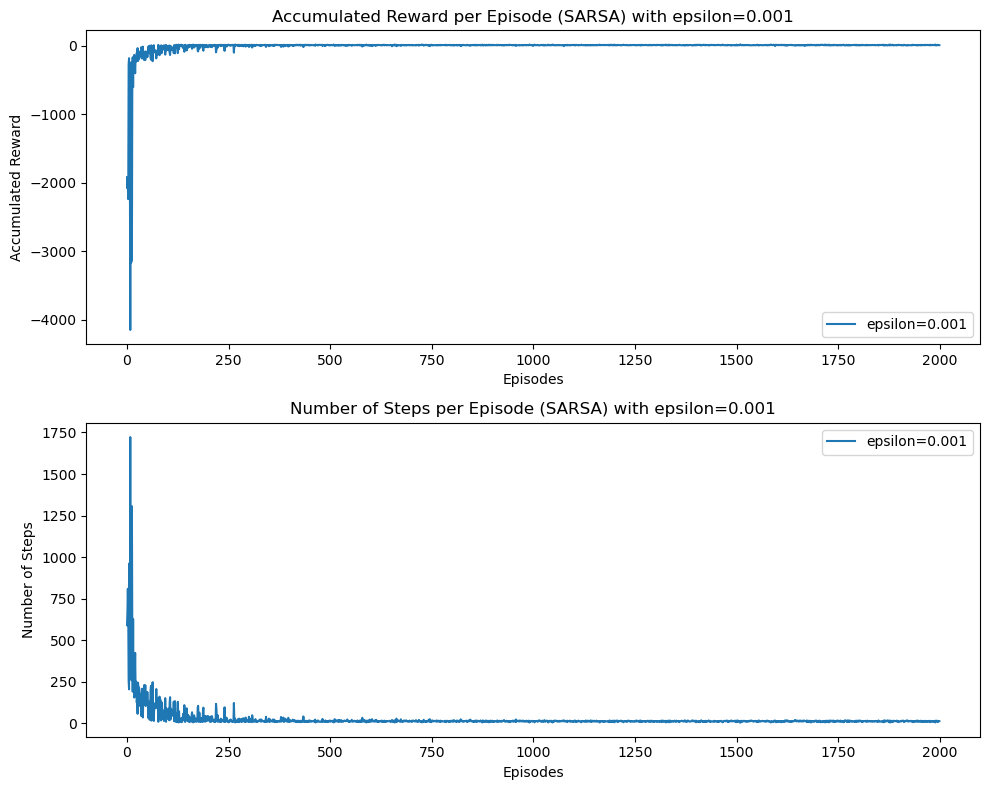

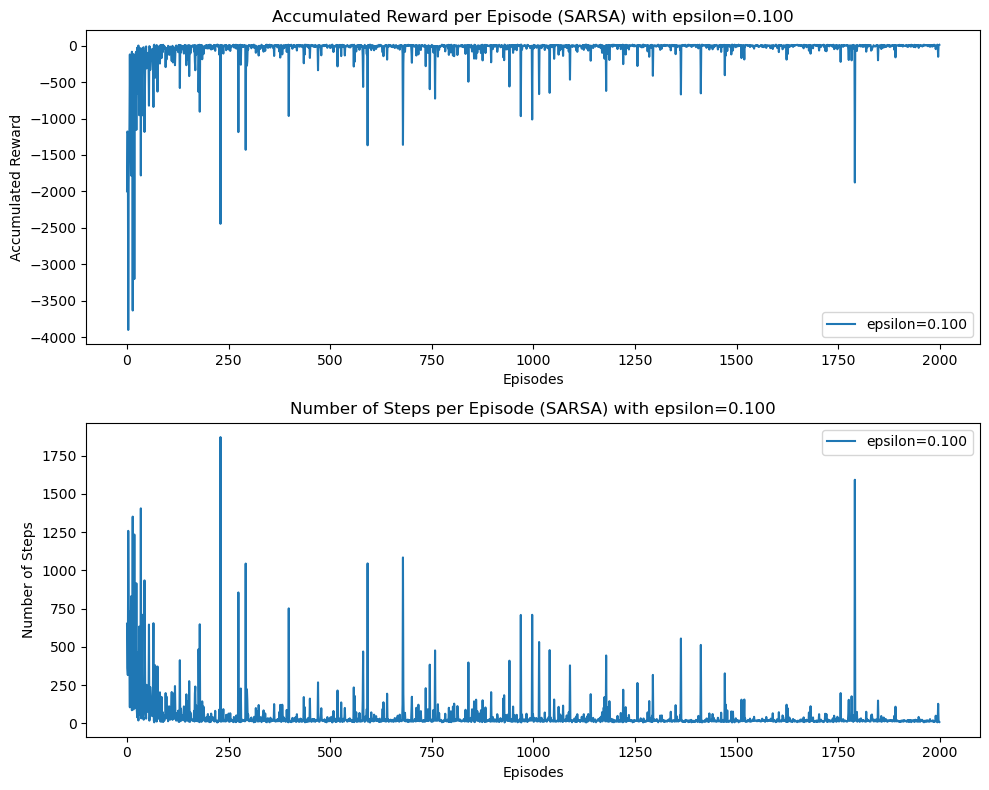

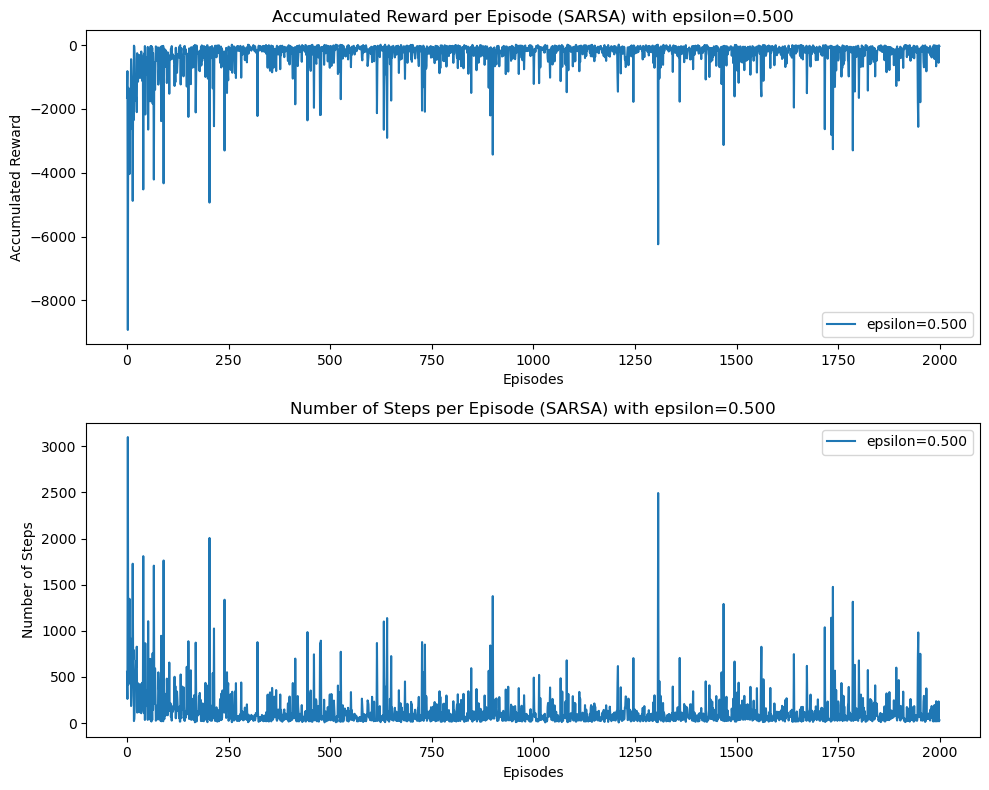

In [10]:
for epsilon, sarsa_rewards, sarsa_steps in sarsa_results:
    plt.figure(figsize=(10, 8))

    # Plot the accumulated rewards per episode for SARSA
    plt.subplot(2, 1, 1)
    plt.plot(range(episodes), sarsa_rewards, label=f'epsilon={epsilon:.3f}')
    plt.xlabel('Episodes')
    plt.ylabel('Accumulated Reward')
    plt.title(f'Accumulated Reward per Episode (SARSA) with epsilon={epsilon:.3f}')
    plt.legend()

    # Plot the number of steps per episode for SARSA
    plt.subplot(2, 1, 2)
    plt.plot(range(episodes), sarsa_steps, label=f'epsilon={epsilon:.3f}')
    plt.xlabel('Episodes')
    plt.ylabel('Number of Steps')
    plt.title(f'Number of Steps per Episode (SARSA) with epsilon={epsilon:.3f}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


# Step 6: Start the training and plot the rewards and steps for the two methods

### When $\epsilon$ is set to 0 in the epsilon-greedy method, the agent always selects the action with the highest Q-value for the current state, effectively becoming a greedy method. 
### After the experiments, now I've set the exploration parameter $\epsilon$ to 0.001

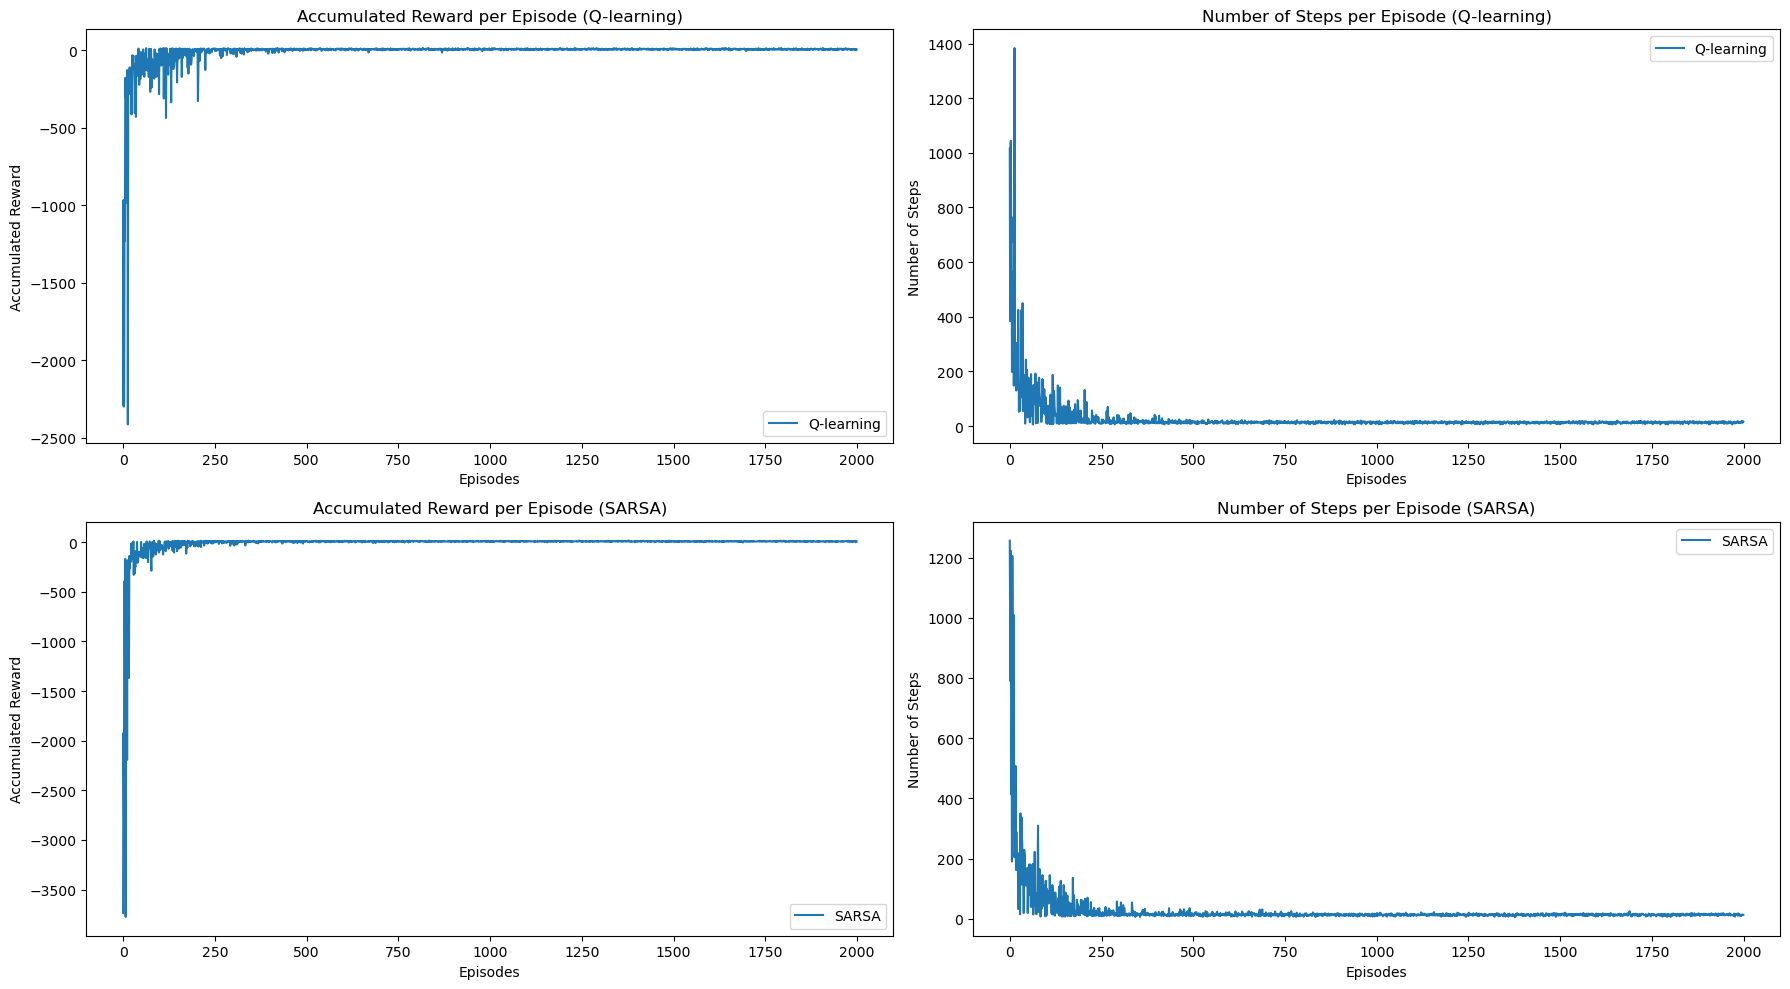

In [11]:
# Setting the exploration parameter epsilon to 0.001
epsilon = 0.001

# Training the agent using Q-learning with epsilon-greedy method
Q = np.zeros([n_states, n_actions])  # Initialize Q-table
Q, q_rewards, q_steps = q_learning(env, Q, alpha, gamma, episodes, epsilon, method='epsilon_greedy')

# Training the agent using SARSA with epsilon-greedy method
Q_sarsa = np.zeros([n_states, n_actions])  # Initialize SARSA Q-table
Q_sarsa, sarsa_rewards, sarsa_steps = sarsa(env, Q_sarsa, alpha, gamma, episodes, epsilon, method='epsilon_greedy')

# Save Q-learning and SARSA Q-table
np.save('q_learning_q_table.npy', Q)
np.save('sarsa_q_table.npy', Q_sarsa)

# Plot the accumulated rewards per episode for Q-learning
plt.figure(figsize=(18, 10))

plt.subplot(2, 2, 1)
plt.plot(range(episodes), q_rewards, label='Q-learning')
plt.xlabel('Episodes')
plt.ylabel('Accumulated Reward')
plt.title('Accumulated Reward per Episode (Q-learning)')
plt.legend()

# Plot the number of steps per episode for Q-learning
plt.subplot(2, 2, 2)
plt.plot(range(episodes), q_steps, label='Q-learning')
plt.xlabel('Episodes')
plt.ylabel('Number of Steps')
plt.title('Number of Steps per Episode (Q-learning)')
plt.legend()

# Plot the accumulated rewards per episode for SARSA
plt.subplot(2, 2, 3)
plt.plot(range(episodes), sarsa_rewards, label='SARSA')
plt.xlabel('Episodes')
plt.ylabel('Accumulated Reward')
plt.title('Accumulated Reward per Episode (SARSA)')
plt.legend()

# Plot the number of steps per episode for SARSA
plt.subplot(2, 2, 4)
plt.plot(range(episodes), sarsa_steps, label='SARSA')
plt.xlabel('Episodes')
plt.ylabel('Number of Steps')
plt.title('Number of Steps per Episode (SARSA)')
plt.legend()

plt.tight_layout()
plt.show()

# Step 7: Visualizing the trained agent for both the Q-learning and SARSA

### 1) Visualizing the Q-learning trained agent

In [12]:
# Create the Taxi-v3 environment with rendering mode set to 'ansi' for text output
test_env = gym.make('Taxi-v3', render_mode='ansi')

# Reset the environment to get the initial state
state_info = test_env.reset()

# Extract the initial state from the reset information
state = state_info[0]

# Initialize the 'done' flag to None
done = None

# Render the initial environment state
rendered_test_env = test_env.render()

# Initialize a step counter and the acuumulated reward counter
i = 0
total_accumulated_reward = 0

# Dictionary to map action indices to their descriptions
action_dict = {
    0: "Move South",
    1: "Move North",
    2: "Move East",
    3: "Move West",
    4: "Pick Up Passenger",
    5: "Drop Off Passenger"
}

# Print the initial state of the environment
print(f"Initial map:")
print(rendered_test_env)

# Loop until the episode is done
while not done:
    # Select the action with the highest Q-value for the current state (greedy)
    action = np.argmax(Q[state])
    state, reward, done, info, _ = test_env.step(action)
    
    # Get the description of the action performed
    output = action_dict.get(action)
    
    # Accumulate the total reward
    total_accumulated_reward += reward
    
    # Print the step number and the action taken
    print(f'Step:{i}', output)
    print(f'State: {state}, Action: {action} ({output}), Reward: {reward}, Total Accumulated Reward: {total_accumulated_reward} (Q-Learning)')
    
    # Render and print the environment state after the action
    rendered_map = test_env.render()
    print(rendered_map)
    
    # Increase the step counter
    i += 1
    
# Close the environment
test_env.close()

Initial map:
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


Step:0 Move West
State: 161, Action: 3 (Move West), Reward: -1, Total Accumulated Reward: -1 (Q-Learning)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Step:1 Move West
State: 141, Action: 3 (Move West), Reward: -1, Total Accumulated Reward: -2 (Q-Learning)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Step:2 Move South
State: 241, Action: 0 (Move South), Reward: -1, Total Accumulated Reward: -3 (Q-Learning)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Step:3 Move West
State: 221, Action: 3 (Move West), Reward: -1, Total Accumulated Reward: -4 (Q-Learning)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Step:4 Move North
State: 121, Action: 1 (Move North), Reward: -1, Total Accumulated Reward: -5 (Q-

### 2) Visualizing the SARSA trained agent

In [13]:
# Create the Taxi-v3 environment with rendering mode set to 'ansi' for text output
test_env = gym.make('Taxi-v3', render_mode='ansi')

# Reset the environment to get the initial state
state_info = test_env.reset()

# Extract the initial state from the reset information
state = state_info[0]

# Initialize the 'done' flag to None
done = None

# Render the initial environment state
rendered_test_env = test_env.render()

# Initialize a step counter and the acuumulated reward counter
i = 0
total_accumulated_reward = 0

# Dictionary to map action indices to their descriptions
action_dict = {
    0: "Move South",
    1: "Move North",
    2: "Move East",
    3: "Move West",
    4: "Pick Up Passenger",
    5: "Drop Off Passenger"
}

# Print the initial state of the environment
print(f"Initial map:")
print(rendered_test_env)

# Loop until the episode is done
while not done:
    # Select the action with the highest Q-value for the current state (greedy)
    action = np.argmax(Q_sarsa[state])
    state, reward, done, info, _ = test_env.step(action)
    
    # Get the description of the action performed
    output = action_dict.get(action)
    
    # Accumulate the total reward
    total_accumulated_reward += reward
    
    # Print the step number and the action taken
    print(f'Step:{i}', output)
    print(f'State: {state}, Action: {action} ({output}), Reward: {reward}, Total Accumulated Reward: {total_accumulated_reward} (SARSA)')
    
    # Render and print the environment state after the action
    rendered_map = test_env.render()
    print(rendered_map)
    
    # Increase the step counter
    i += 1
    
# Close the environment
test_env.close()

Initial map:
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


Step:0 Move East
State: 267, Action: 2 (Move East), Reward: -1, Total Accumulated Reward: -1 (SARSA)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Step:1 Move North
State: 167, Action: 1 (Move North), Reward: -1, Total Accumulated Reward: -2 (SARSA)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Step:2 Move North
State: 67, Action: 1 (Move North), Reward: -1, Total Accumulated Reward: -3 (SARSA)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Step:3 Move East
State: 87, Action: 2 (Move East), Reward: -1, Total Accumulated Reward: -4 (SARSA)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Step:4 Pick Up Passenger
State: 99, Action: 4 (Pick Up Passenger), Reward: -1, Total Accumulated Reward: -5 (SARSA)
+

In [14]:
# Code Delimiter
pass

# Step 8: Script for Testing and Discussing

### Calculate the average number of steps per episode and the average accumulated reward (for a maximum of `100` steps for each episode) for the test episodes (using the greedy action selection method).

### After training the two algorithms and based on the two saved Q-tables, the algorithms will be tested on **at least** `100` random grid-world scenarios with the same characteristics as the taxi environment for both the Q-learning and SARSA algorithms using the greedy action selection method. Therefore, the Q-tables will not be updated during testing for the new steps.

In [15]:
# Import the necessary packages
import gym
import numpy as np
import matplotlib.pyplot as plt

# Test the trained agent in the environment using a given Q-table
def test_agent(env, Q, epi):
    total_rewards = []
    total_steps = []

    # Run 10 - 100 episodes for testing
    for _ in range(epi):
        state_info = env.reset()
        state = state_info[0]
        episode_reward = 0
        step_count = 0
        done = False

        # Continue until the episode is done or step limit is reached
        while not done:
            # Select the action with the highest Q-value for the current state (greedy)
            action = np.argmax(Q[state])
            next_state_info, reward, done, _, _ = env.step(action)
            next_state = next_state_info

            # Q-table will not be updated during testing for the new steps

            # Accumulate the reward for the current episode
            episode_reward += reward
            state = next_state
            step_count += 1

            if step_count == 100:
                # Ensure no reward is given if the agent does not reach the goal
                # print(len(total_steps), step_count, episode_reward)
                episode_reward = 0
                # Breaks the loop
                break

        # Store the total rewards and steps for the current episode
        total_rewards.append(episode_reward)
        total_steps.append(step_count)
        
    return total_rewards, total_steps

#### For Q-learning algorithm, the agent should perform at `<14` steps per episode on average and obtain a `>7` average accumulated reward.

#### For SARSA algorithm, the agent should perform at `<15` steps per episode on average and obtain a `>5` average accumulated reward.

Average of 100 episodes:
Q-learning: [R>7, S<14]
Average rewards: 7.19
Average steps: 13.81

SARSA: [R>5, S<15]
Average rewards: 7.73
Average steps: 13.27



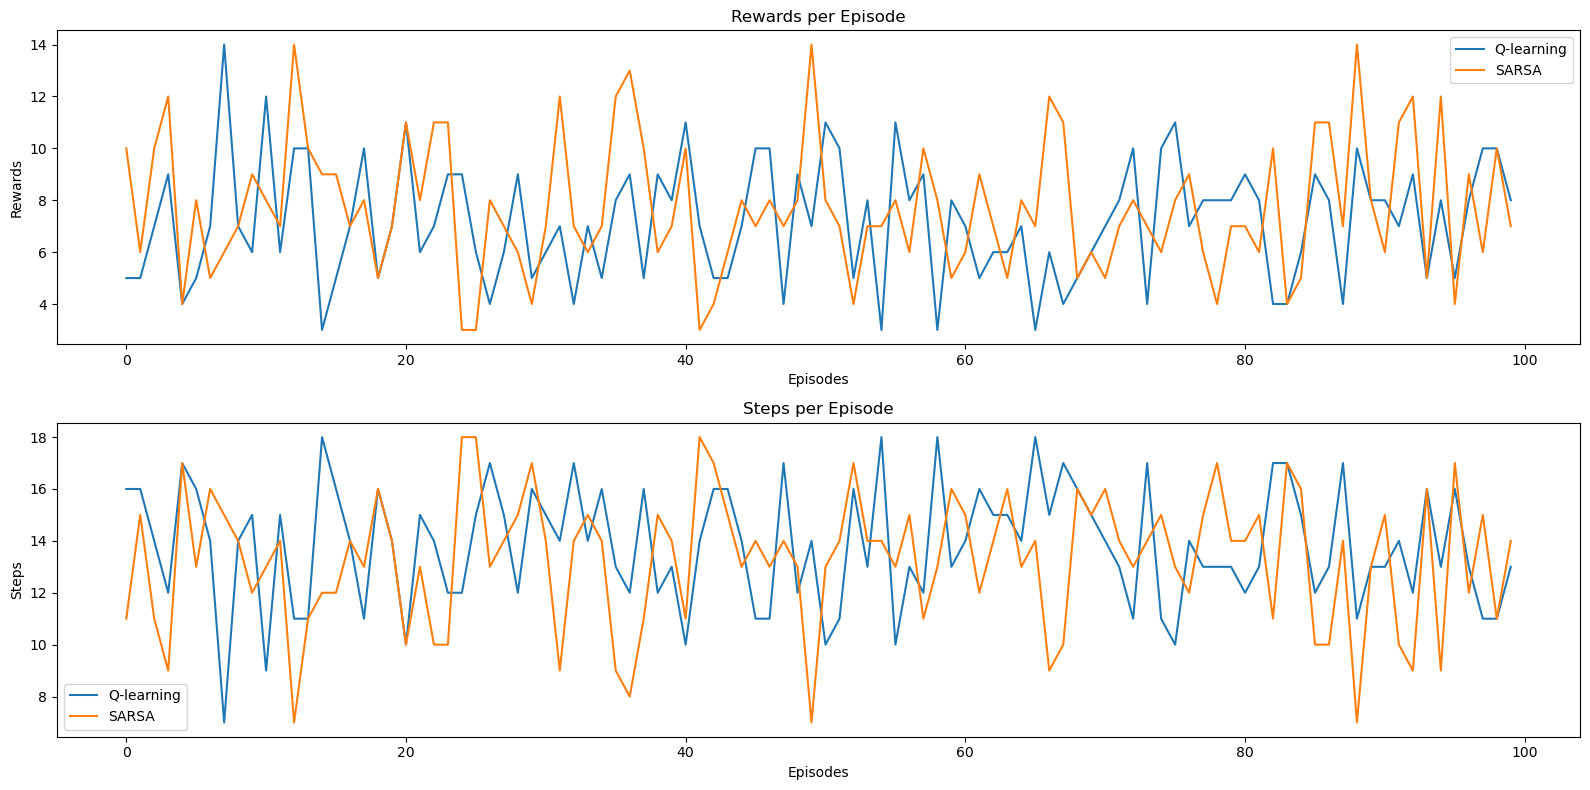

Average of 300 episodes:
Q-learning: [R>7, S<14]
Average rewards: 7.94
Average steps: 13.06

SARSA: [R>5, S<15]
Average rewards: 7.96
Average steps: 13.04



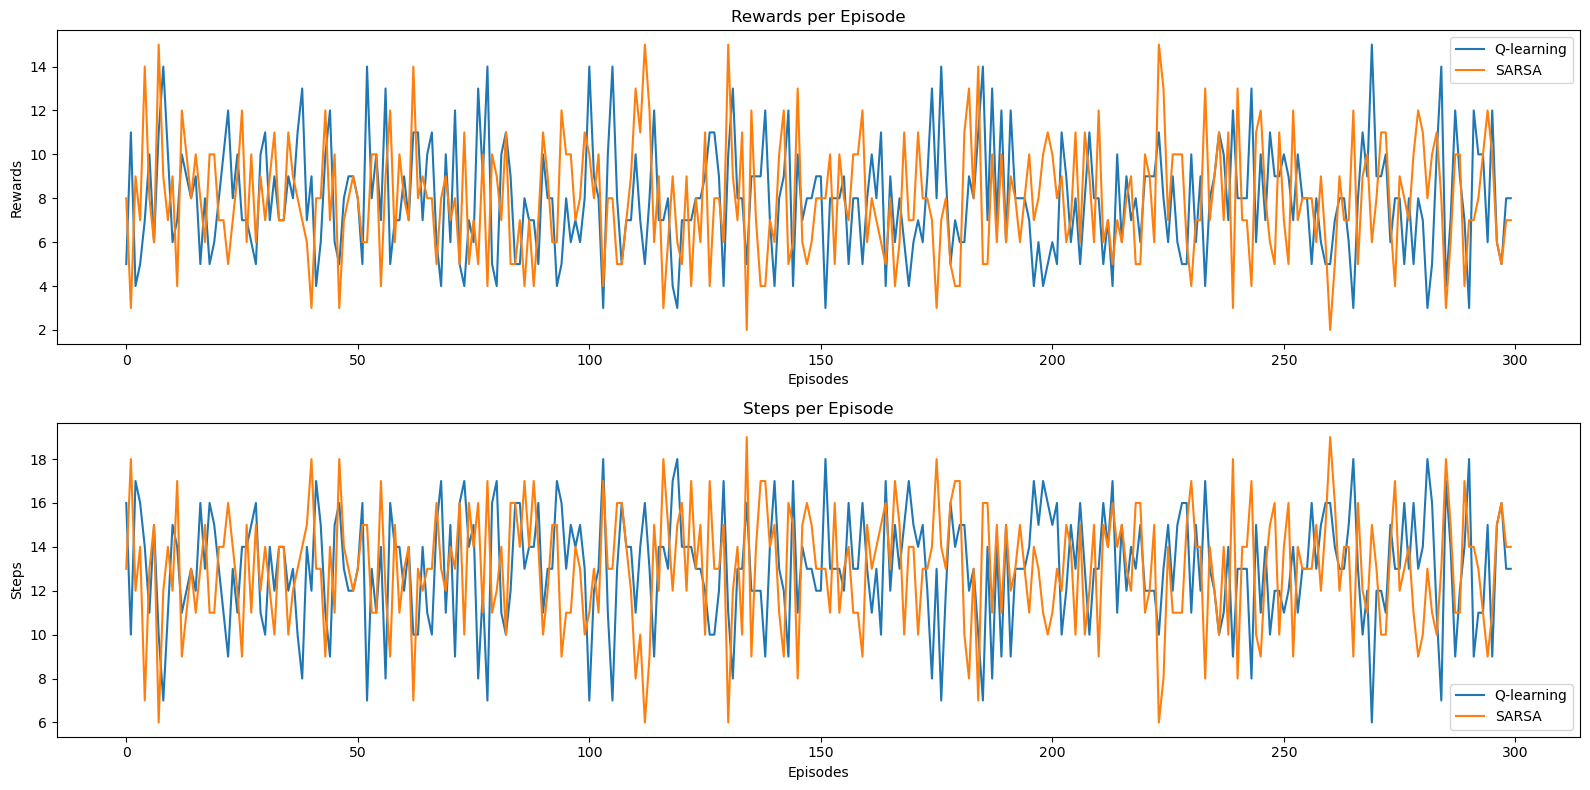

Average of 1000 episodes:
Q-learning: [R>7, S<14]
Average rewards: 7.75
Average steps: 13.25

SARSA: [R>5, S<15]
Average rewards: 8.02
Average steps: 12.98



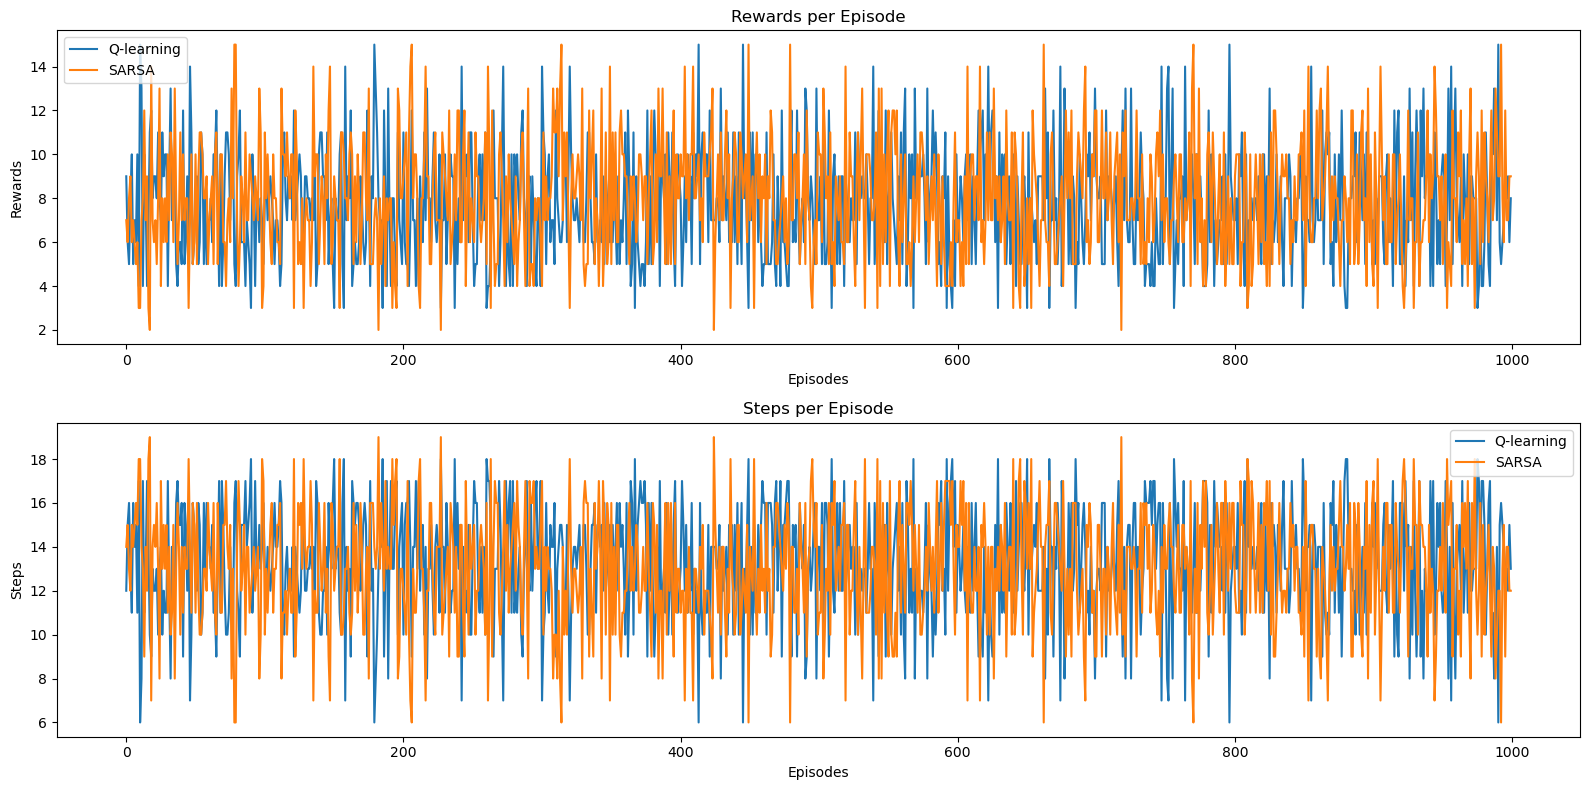

In [16]:
# Create the Taxi-v3 environment
env = gym.make('Taxi-v3')

# Episodes list for average rewards and steps testing (At least 100 random scenarios)
epis = [100, 300, 1000]
# epis = [100000]

# Load the Q-table trained using Q-learning from a file
test_Q = np.load('q_learning_q_table.npy')

# Load the Q-table trained using SARSA from a file
test_Q_sarsa = np.load('sarsa_q_table.npy')

# Calculate average with 10 different numbers of episodes
for epi in epis:
    print(f"Average of {epi} episodes:")
    
    # Test the agent using the loaded Q-table
    # Calculate the average reward and number of steps per episode
    total_rewards_q_learning, total_steps_q_learning = test_agent(env, test_Q, epi)
    avg_reward_q_learning = np.mean(total_rewards_q_learning)
    avg_steps_q_learning = np.mean(total_steps_q_learning)
    print(f"Q-learning: [R>7, S<14]")
    print(f"Average rewards: {avg_reward_q_learning:.2f}")
    print(f"Average steps: {avg_steps_q_learning:.2f}")
    print()

    # Test the agent using the loaded SARSA Q-table
    total_rewards_q_sarsa, total_steps_q_sarsa = test_agent(env, test_Q_sarsa, epi)
    avg_reward_q_sarsa = np.mean(total_rewards_q_sarsa)
    avg_steps_q_sarsa = np.mean(total_steps_q_sarsa)
    print(f"SARSA: [R>5, S<15]")
    print(f"Average rewards: {avg_reward_q_sarsa:.2f}")
    print(f"Average steps: {avg_steps_q_sarsa:.2f}")
    print()
    
    # Plotting the rewards
    plt.figure(figsize=(16, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_rewards_q_learning, label='Q-learning')
    plt.plot(total_rewards_q_sarsa, label='SARSA')
    plt.xlabel('Episodes')
    plt.ylabel('Rewards')
    plt.title('Rewards per Episode')
    plt.legend()

    # Plotting the steps
    plt.subplot(2, 1, 2)
    plt.plot(total_steps_q_learning, label='Q-learning')
    plt.plot(total_steps_q_sarsa, label='SARSA')
    plt.xlabel('Episodes')
    plt.ylabel('Steps')
    plt.title('Steps per Episode')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Step 9: Visualizing the trained agent for both the Q-learning and SARSA using saved Q values

### 1) Visualizing the Q-learning trained agent using saved Q values

In [17]:
# Create the Taxi-v3 environment with rendering mode set to 'ansi' for text output
test_env = gym.make('Taxi-v3', render_mode='ansi')

# Reset the environment to get the initial state
state_info = test_env.reset()

# Extract the initial state from the reset information
state = state_info[0]

# Initialize the 'done' flag to None
done = None

# Render the initial environment state
rendered_test_env = test_env.render()

# Initialize a step counter and the acuumulated reward counter
i = 0
total_accumulated_reward = 0

# Dictionary to map action indices to their descriptions
action_dict = {
    0: "Move South",
    1: "Move North",
    2: "Move East",
    3: "Move West",
    4: "Pick Up Passenger",
    5: "Drop Off Passenger"
}

# Print the initial state of the environment
print(f"Initial map:")
print(rendered_test_env)

# Loop until the episode is done
while not done:
    # Select the action with the highest Q-value for the current state (greedy)
    action = np.argmax(test_Q[state])
    state, reward, done, info, _ = test_env.step(action)
    
    # Get the description of the action performed
    output = action_dict.get(action)
    
    # Accumulate the total reward
    total_accumulated_reward += reward
    
    # Print the step number and the action taken
    print(f'Step:{i}', output)
    print(f'State: {state}, Action: {action} ({output}), Reward: {reward}, Total Accumulated Reward: {total_accumulated_reward} (Q-Learning)')
    
    # Render and print the environment state after the action
    rendered_map = test_env.render()
    print(rendered_map)
    
    # Increase the step counter
    i += 1
    
# Close the environment
test_env.close()

Initial map:
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


Step:0 Move South
State: 229, Action: 0 (Move South), Reward: -1, Total Accumulated Reward: -1 (Q-Learning)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Step:1 Move West
State: 209, Action: 3 (Move West), Reward: -1, Total Accumulated Reward: -2 (Q-Learning)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Step:2 Move South
State: 309, Action: 0 (Move South), Reward: -1, Total Accumulated Reward: -3 (Q-Learning)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Step:3 Move South
State: 409, Action: 0 (Move South), Reward: -1, Total Accumulated Reward: -4 (Q-Learning)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Step:4 Pick Up Passenger
State: 417, Action: 4 (Pick Up Passenger), Reward: -1, Total Accumu

### 2) Visualizing the SARSA trained agent using saved Q values

In [18]:
# Create the Taxi-v3 environment with rendering mode set to 'ansi' for text output
test_env = gym.make('Taxi-v3', render_mode='ansi')

# Reset the environment to get the initial state
state_info = test_env.reset()

# Extract the initial state from the reset information
state = state_info[0]

# Initialize the 'done' flag to None
done = None

# Render the initial environment state
rendered_test_env = test_env.render()

# Initialize a step counter and the acuumulated reward counter
i = 0
total_accumulated_reward = 0

# Dictionary to map action indices to their descriptions
action_dict = {
    0: "Move South",
    1: "Move North",
    2: "Move East",
    3: "Move West",
    4: "Pick Up Passenger",
    5: "Drop Off Passenger"
}

# Print the initial state of the environment
print(f"Initial map:")
print(rendered_test_env)

# Loop until the episode is done
while not done:
    # Select the action with the highest Q-value for the current state (greedy)
    action = np.argmax(test_Q_sarsa[state])
    state, reward, done, info, _ = test_env.step(action)
    
    # Get the description of the action performed
    output = action_dict.get(action)
    
    # Accumulate the total reward
    total_accumulated_reward += reward
    
    # Print the step number and the action taken
    print(f'Step:{i}', output)
    print(f'State: {state}, Action: {action} ({output}), Reward: {reward}, Total Accumulated Reward: {total_accumulated_reward} (SARSA)')
    
    # Render and print the environment state after the action
    rendered_map = test_env.render()
    print(rendered_map)
    
    # Increase the step counter
    i += 1
    
# Close the environment
test_env.close()

Initial map:
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


Step:0 Move North
State: 202, Action: 1 (Move North), Reward: -1, Total Accumulated Reward: -1 (SARSA)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Step:1 Move North
State: 102, Action: 1 (Move North), Reward: -1, Total Accumulated Reward: -2 (SARSA)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Step:2 Move North
State: 2, Action: 1 (Move North), Reward: -1, Total Accumulated Reward: -3 (SARSA)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Step:3 Pick Up Passenger
State: 18, Action: 4 (Pick Up Passenger), Reward: -1, Total Accumulated Reward: -4 (SARSA)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

Step:4 Move South
State: 118, Action: 0 (Move South), Reward: -1, Total Accumulated Reward: -5 (S

## References

[1] https://www.gymlibrary.dev/environments/toy_text/taxi/#taxi